In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd 
import scipy as sp
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from pykrige.ok import OrdinaryKriging

from dk_model import DeepKrigingTrainer


In [25]:
deposit_data = pd.read_csv("../Curated_data/final_dataset_1_no_0.csv", low_memory=False)


In [26]:
covariates=['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm']

# Deepkriging covariates

In [27]:
trainer_regular = DeepKrigingTrainer(deposit_data, covariates=['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm'], regular_nn=False, plot_errors=False)
trainer_regular.train_neural_network(mode="regular", test_size=0.3)
test_predictions_dk = trainer_regular.test_predictions

Deposit Data MSE: 0.0024, MAE: 0.0333, R2: 0.8363


# NN Covariates

In [28]:
# Create an instance of DeepKrigingTrainer
trainer = DeepKrigingTrainer(deposit_data, covariates=['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm'], regular_nn=True, plot_errors=False)

# Train the neural network (using cross-validation or regular mode)
trainer.train_neural_network(mode="regular", test_size=0.3)
test_predictions_nn = trainer.test_predictions

Deposit Data MSE: 0.0056, MAE: 0.0479, R2: 0.6186


# Reg kriging covariates

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

np.random.seed(42)

# Separate input features (x) and target variable (y)
y = deposit_data['Density_gcm3'].values[:, np.newaxis]  # Keep variable as the output
x = deposit_data[['X', 'Y', 'Z','CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm']].values

# Perform 70:30 train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Fit a linear regression model
regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

# Predictions from the regression model
test_predictions_rk = regression_model.predict(x_test)

# Calculate metrics
mse = mean_squared_error(y_test, test_predictions_rk)
mae = mean_absolute_error(y_test, test_predictions_rk)
sst = np.mean((y_test - np.mean(y_test)) ** 2) * len(y_test)
ssr = np.mean((test_predictions_rk - y_test) ** 2) * len(y_test)
r2 = 1 - (ssr / sst)

# Calculate adjusted R-squared
n = len(y_test)
num_predictors = x_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))

# Print metrics
print(f"Mean Squared Error (MSE): {mse}")
#print(f"Mean Absolute Error (MAE): {mae}")
#print(f"Adjusted R-squared: {adjusted_r2}")


Mean Squared Error (MSE): 0.012730452388159527


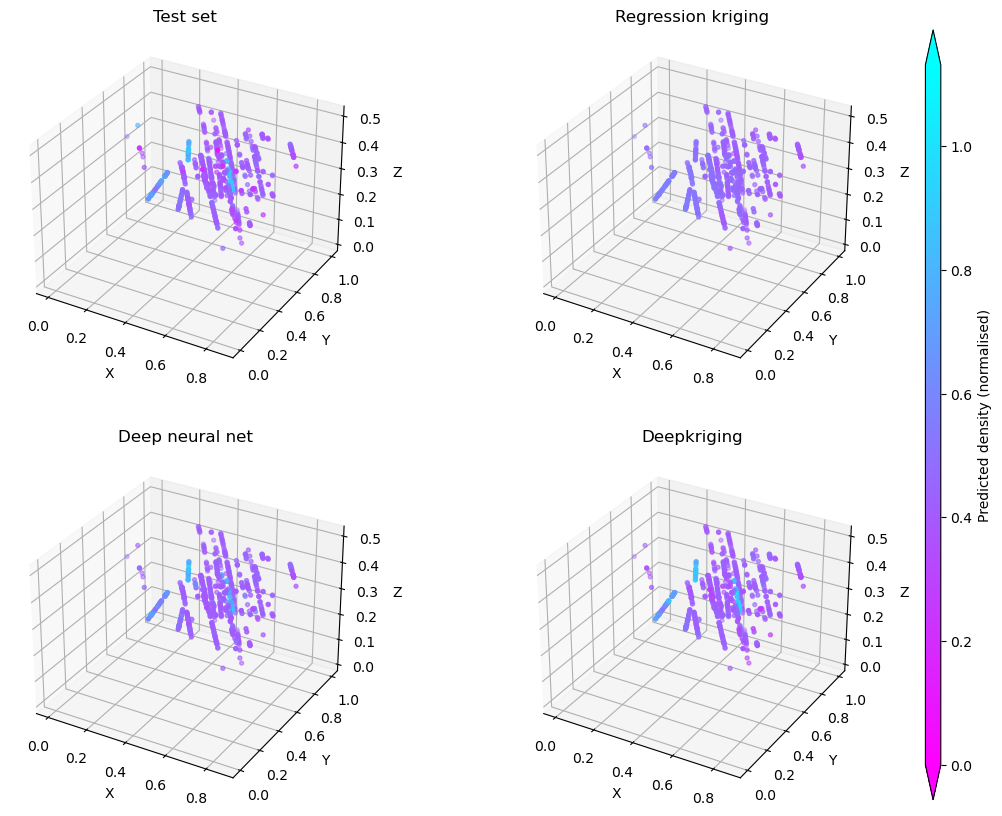

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize

train_data_xyz = train_data[['X', 'Y', 'Z']].values
test_data_xyz = test_data[['X', 'Y', 'Z']].values

all_predictions = np.concatenate([test_predictions_dk.ravel(), test_predictions_nn.ravel(), test_predictions_rk.ravel(), y_test.ravel()])
min_value = all_predictions.min()
max_value = all_predictions.max()

# Define custom colormap using magenta and cyan colors, like the rest of the paper
colors = [(1, 0, 1), (0, 1, 1)]  # Magenta to Cyan
cmap_name = 'MagentaCyan'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

# Create Matplotlib figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={'projection': '3d'})

# Define scatter plots for each subplot with vmin and vmax values
scatter1 = axs[1, 1].scatter(test_data_xyz[:, 0], test_data_xyz[:, 1], test_data_xyz[:, 2], c=test_predictions_dk.ravel(), cmap=custom_cmap, s=8, vmin=min_value, vmax=max_value)
scatter2 = axs[1, 0].scatter(test_data_xyz[:, 0], test_data_xyz[:, 1], test_data_xyz[:, 2], c=test_predictions_nn.ravel(), cmap=custom_cmap, s=8, vmin=min_value, vmax=max_value)
scatter3 = axs[0, 1].scatter(test_data_xyz[:, 0], test_data_xyz[:, 1], test_data_xyz[:, 2], c=test_predictions_rk.ravel(), cmap=custom_cmap, s=8, vmin=min_value, vmax=max_value)
scatter4 = axs[0, 0].scatter(test_data_xyz[:, 0], test_data_xyz[:, 1], test_data_xyz[:, 2], c=y_test.ravel(), cmap=custom_cmap, s=8, vmin=min_value, vmax=max_value)

# Set titles for each subplot
axs[1, 1].set_title('Deepkriging')
axs[1, 0].set_title('Deep neural net')
axs[0, 1].set_title('Regression kriging')
axs[0, 0].set_title('Test set')

# Set common labels for all subplots
for ax in axs.flat:
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

# Create a single colorbar
norm = Normalize(vmin=min_value, vmax=max_value)
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])  # this line is necessary for ScalarMappable to work properly
cbar = fig.colorbar(sm, ax=axs, pad=0.05, aspect=50, extend='both')
cbar.set_label('Predicted density (normalised)')

#plt.tight_layout()
plt.savefig('combined_plots_with_common_colorbar_MagentaCyan_inverted.png')  # Save the plot as PNG
plt.show()
